In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from plasmistry.electron import EEDF
from plasmistry.electron import get_maxwell_eedf
np.set_printoptions(precision=1, linewidth=130, edgeitems=5)

In [2]:
crostn_energy = np.linspace(0,10)
crostn = np.ones_like(crostn_energy)*1e-20
threshold = 5
crostn[crostn_energy<5] = 0
inelas_df = pd.DataFrame(dict(reaction=["E + H2 => E + H2(v1)",], 
                             type=["excitation",],
                             threshold_eV=[5,],
                             cross_section=[np.vstack((crostn_energy, crostn)),]))
inelas_df

,reaction,type,threshold_eV,cross_section
0,E + H2 => E + H2(v1),excitation,5,"[[0.0, 0.20408163265306123, 0.4081632653061224..."


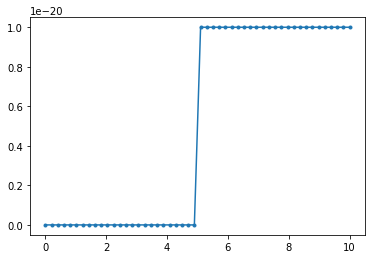

In [48]:
_cs = inelas_df.at[0, "cross_section"]
plt.plot(_cs[0],_cs[1], marker='.')

# Creation
##     *parameters*
* **max_energy_eV** : *number*
* **grid_number** : *number*

In [4]:
eedf = EEDF(max_energy_eV=10, grid_number=200)

# initialize
## *parameters*
* **rctn_with_crostn_df** : *data frame*
* **total_species** : *list*

In [5]:
eedf.initialize(rctn_with_crostn_df=inelas_df, total_species=['E', 'H2'])

KeyError: 'formula'

# Set parameters
* **E** : *float*
* **Tgas** : *float*
* **N** : *float*

In [0]:
eedf.set_parameters(E=100, Tgas=1000, N=1e20)

# See the rate const matrix of electron

In [0]:
eedf.rate_const_matrix_e_inelas_electron.toarray()

In [0]:
eedf.rate_const_matrix_e_inelas_electron.shape

In [0]:
plt.spy(eedf.rate_const_matrix_e_inelas_electron, markersize=2)

# See the rate const matrix of molecule

In [0]:
eedf.rate_const_matrix_e_inelas_molecule

In [0]:
eedf.rate_const_matrix_e_inelas_molecule.shape

In [0]:
plt.plot(eedf.energy_point_eV, eedf.rate_const_matrix_e_inelas_molecule[0], marker='.')

# See the eedf properties

In [0]:
eedf.set_density_per_J(get_maxwell_eedf(eedf.energy_point, Te_eV=3.0))

In [0]:
eedf.set_flux(total_species_density=np.array([1,1]))

In [0]:
eedf.J_flux_ee

In [0]:
print(eedf)

In [0]:
eedf.plot_normalized_eedf()

In [0]:
eedf.plot_normalized_eepf()

In [0]:
eedf._get_electron_rate_e_inelas(density=np.array([1,1]))

# time evolution
## function
* **solve_ivp** : BDF method

In [0]:
total_species_density = np.array([1,1])*1e25
def dndt(t, y):
    eedf.set_density_per_J(y)
    print(t)
    return eedf._get_electron_rate_e_inelas(density=total_species_density)

def dndt_ef(t, y):
    eedf.set_density_per_J(y)
    eedf.set_flux(total_species_density=total_species_density)
    print(t)
    return eedf._get_deriv_ef()

def dndt_el(t, y):
    eedf.set_density_per_J(y)
    eedf.set_flux(total_species_density=total_species_density)
    print(t)
    return eedf._get_deriv_el()

def dndt_ee(t, y):
    eedf.set_density_per_J(y)
    eedf.set_flux(total_species_density=total_species_density)
    print(t)
    return eedf._get_deriv_ee()

def dndt_all(t, y):
    eedf.set_density_per_J(y)
    eedf.set_flux(total_species_density=total_species_density)
    print(t)
    return eedf.get_deriv_total(total_species_density=total_species_density)  

In [0]:
y0 = eedf.density_per_J
sol = solve_ivp(dndt, [0,10],y0, method="BDF")

In [0]:
sol.t

In [0]:
sol.y

In [0]:
plt.plot(eedf.energy_point_eV, sol.y)

In [0]:
print(f"y: shape {sol.y.shape}, t: shape {sol.t.shape}")

In [0]:
eedf.set_density_per_J(sol.y[:,0])
eedf.plot_normalized_eepf()

In [0]:
eedf.plot_normalized_eedf()

In [0]:
eedf.set_density_per_J(sol.y[:,-1])
eedf.plot_normalized_eepf()

###  -*electric field*- effect only

In [0]:
y0 = eedf.density_per_J
sol = solve_ivp(dndt_ef, [0,10],y0, method="BDF")

In [0]:
eedf.set_density_per_J(sol.y[:,-1])
eedf.plot_normalized_eepf()

In [0]:
eedf.plot_normalized_eedf()

In [0]:
Te_seq = []
for _array in sol.y.transpose():
    eedf.set_density_per_J(_array)
    Te_seq.append(eedf.electron_temperature_in_eV)
plt.semilogx(sol.t, Te_seq, marker='.')

### -*elastic collision*- effect only

In [0]:
y0 = get_maxwell_eedf(eedf.energy_point, Te_eV=1.0)
sol = solve_ivp(dndt_el, [0,10],y0, method="BDF")

In [0]:
plt.plot(eedf.energy_point_eV, sol.y[:,::40])

In [0]:
eedf.set_density_per_J(sol.y[:,-1])
eedf.plot_normalized_eepf()

In [0]:
eedf.plot_normalized_eedf()

In [0]:
Te_seq = []
for _array in sol.y.transpose():
    eedf.set_density_per_J(_array)
    Te_seq.append(eedf.electron_density)
plt.semilogx(sol.t, Te_seq, marker='.')

### -*electron collisions*- only

In [0]:
y0 = 1e20 * get_maxwell_eedf(eedf.energy_point, Te_eV=1.0)
y0[eedf.energy_point_eV>2] = 1e-30
sol = solve_ivp(dndt_ee, [0,1e3],y0, method="BDF")

In [0]:
plt.plot(eedf.energy_point_eV, sol.y[:,::40])

In [0]:
eedf.electron_density

In [0]:
eedf.set_density_per_J(sol.y[:,0])
eedf.plot_normalized_eepf()

In [0]:
eedf.set_density_per_J(sol.y[:,-1])
eedf.plot_normalized_eepf()

In [0]:
Te_seq = []
for _array in sol.y.transpose():
    eedf.set_density_per_J(_array)
    Te_seq.append(eedf.electron_density)
plt.semilogx(sol.t, Te_seq, marker='.')

### together all effects

In [0]:
y0 = 1e20 * get_maxwell_eedf(eedf.energy_point, Te_eV=1.0)
sol = solve_ivp(dndt_all, [0,1e3],y0, method="BDF")

In [0]:
eedf.set_density_per_J(sol.y[:,0])
eedf.plot_normalized_eepf()

In [0]:
eedf.set_density_per_J(sol.y[:,-1])
eedf.plot_normalized_eepf()

In [0]:
Te_seq = []
for _array in sol.y.transpose():
    eedf.set_density_per_J(_array)
    Te_seq.append(eedf.electron_density)
plt.semilogx(sol.t, Te_seq, marker='.')